In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.optimize as sco
!pip install yfinance
import yfinance as yf

In [22]:
tickerSymbol = ['WMT', 'HD', 'ABT', 'SNPS', 'ACN', 'BTC-USD', 'TIP', 'COKE', 'SQ']

start_date = '2010-01-01'
end_date = '2023-02-25'

data = yf.download(tickerSymbol, start=start_date, end=end_date)['Adj Close']
data

[*********************100%***********************]  9 of 9 completed


,ABT,ACN,BTC-USD,COKE,HD,SNPS,SQ,TIP,WMT
Date,,,,,,,,,
2010-01-04,19.433037,32.836594,NaN,47.322105,21.122955,22.440001,NaN,75.740128,40.329685
2010-01-05,19.276031,33.039536,NaN,46.130005,21.277676,22.250000,NaN,75.987366,39.928101
2010-01-06,19.383080,33.390762,NaN,46.315437,21.204000,22.209999,NaN,75.791061,39.838856
2010-01-07,19.543655,33.359550,NaN,45.679653,21.454493,22.150000,NaN,75.907402,39.861168
2010-01-08,19.643574,33.226852,NaN,45.476551,21.351358,22.309999,NaN,76.067337,39.660374
...,...,...,...,...,...,...,...,...,...
2023-02-20,NaN,NaN,24829.148438,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21,103.650002,269.149994,24436.353516,519.150024,295.500000,352.350006,71.949997,106.970001,147.330002
2023-02-22,102.690002,269.630005,24188.843750,520.000000,296.299988,355.059998,72.940002,106.910004,144.240005


In [23]:
data=data.astype('float64')

In [24]:
data.isnull().sum()

ABT         958
ACN         958
BTC-USD    1184
COKE        958
HD          958
SNPS        958
SQ         2439
TIP         958
WMT         958
dtype: int64

In [25]:
rets = np.log(data/ data.shift(1))

In [26]:
noa = len(tickerSymbol)
weights = np.random.random(noa) # Random portfolio weights
weights /= np.sum(weights) # normalized to 1 or 100%

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [27]:
prets = []
pvols = []
for p in range (2500):
    
    # Monte Carlo simulation of portfolio weights.
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    
    #Collects the resulting statistics in list objects.
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

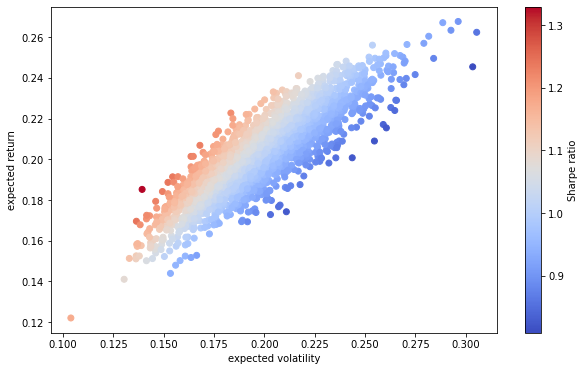

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Maximise the sharpe ratio by minimising the negative sharpe ratio 

In [29]:
# Function to be minimized.
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for the parameters.
bnds = tuple((0, 1) for x in range(noa))

# Equal weights vector.
eweights = np.array(noa * [1. / noa,])
eweights

# The optimization (i.e., minimization of function min_func_sharpe())
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

# The results from the optimization.
opts

     fun: -1.5888391653985041
     jac: array([-8.02591443e-04,  1.24757662e-01, -3.48241627e-03, -1.77226961e-03,
        1.88484788e-04, -2.72035599e-04,  3.29065396e+00,  1.99794769e-04,
        7.05741450e-01])
 message: 'Optimization terminated successfully'
    nfev: 149
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([7.51261250e-02, 1.30819834e-15, 1.16878193e-02, 2.18249981e-02,
       1.14193450e-01, 7.85579428e-02, 4.80645797e-15, 6.98609665e-01,
       2.10991164e-15])

In [30]:
# The optimal portfolio weights.
opts['x'].round(3)

array([0.075, 0.   , 0.012, 0.022, 0.114, 0.079, 0.   , 0.699, 0.   ])

The most efficient portfolio consists of :
ABT - 7.5%
ACN - 0%
BTC-USD - 1.2%
COKE - 2.2%
HD - 11.4%
SNPS - 7.9%
TIP - 69.9%
WNT - 0%

In [33]:
# The resulting portfolio return
port_ret(opts['x']).round(3)

0.105

In [34]:
# The resulting portfolio volatility.
port_vol(opts['x']).round(3)

0.066

In [35]:
# The maximum Sharpe ratio.
port_ret(opts['x']) / port_vol(opts['x'])

1.5888391653985041

The max sharpe ratio is 1.5 illustrating there are adequite returns for the amount of risk taken on by the portfolio 

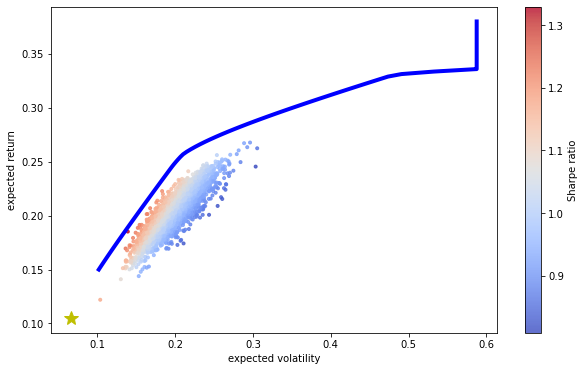

In [36]:
# The two binding constraints for the efficient frontier.
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, 
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0, 1) for x in weights)

# The minimization of portfolio volatility for different target returns.
trets = np.linspace(0.15, 0.38, 100)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', 
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')